In [1]:
import pandas as pd
import glob

financial_statements_files = glob.glob("/workspace/data/preprocessed/financial_statements/*.csv")
financial_statements = pd.concat((pd.read_csv(f, delimiter="\t") for f in financial_statements_files), ignore_index=True)
financial_statements.loc[:, "ddate"] = pd.to_datetime(financial_statements["ddate"], format="%Y%m%d")
financial_statements.loc[:, "filed"] = pd.to_datetime(financial_statements["filed"], format="%Y%m%d")
financial_statements.loc[:, "cik"] = financial_statements["cik"].astype(str).str.zfill(10)

In [34]:
financial_statements["tag"].unique()

array(['AccountsPayableCurrent', 'AccountsReceivableNetCurrent',
       'AccruedLiabilitiesCurrent',
       'AccumulatedOtherComprehensiveIncomeLossNetOfTax',
       'AdditionalPaidInCapital',
       'AdjustmentsNoncashItemsToReconcileNetIncomeLossToCashProvidedByUsedInOperatingActivitiesOther',
       'AdjustmentsToAdditionalPaidInCapitalTaxEffectFromShareBasedCompensation',
       'Assets', 'AssetsCurrent', 'CapitalLeaseObligationsIncurred',
       'CashAndCashEquivalentsAtCarryingValue',
       'CashAndCashEquivalentsPeriodIncreaseDecrease',
       'CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsPeriodIncreaseDecreaseIncludingExchangeRateEffect',
       'CommitmentsAndContingencies',
       'CommonStockParOrStatedValuePerShare', 'CommonStockValue',
       'ComprehensiveIncomeNetOfTax',
       'ContractWithCustomerLiabilityCurrent',
       'CostOfGoodsAndServicesSold', 'CostsAndExpenses',
       'DeferredIncomeTaxExpenseBenefit', 'DeferredRevenueCurrent',
       'Deferr

In [68]:
MAG7_CIKS = {
    "0000320193": "AAPL",
    "0000789019": "GOOGL",
    "0001018724": "AMZN",
    "0001318605": "META",
    "0001652044": "MSFT",
    "0001326801": "TSLA",
    "0001045810": "NVDA",
}

METRICS = ["P/E"]

metrics_df = pd.DataFrame(
    columns=["Company", "Metric", "Value", "Date"]
    # index=pd.date_range(start="2008", end="2026", freq="Q")
)

metrics_df

,Company,Metric,Value,Date


In [ ]:
financial_statements["company"] = financial_statements["cik"].map(MAG7_CIKS)

series = financial_statements.pivot_table(
    columns=["company", "tag", "qtrs"],
    values="value",
    index="ddate"
)

### P/E

/tmp/ipykernel_10251/2684100773.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([


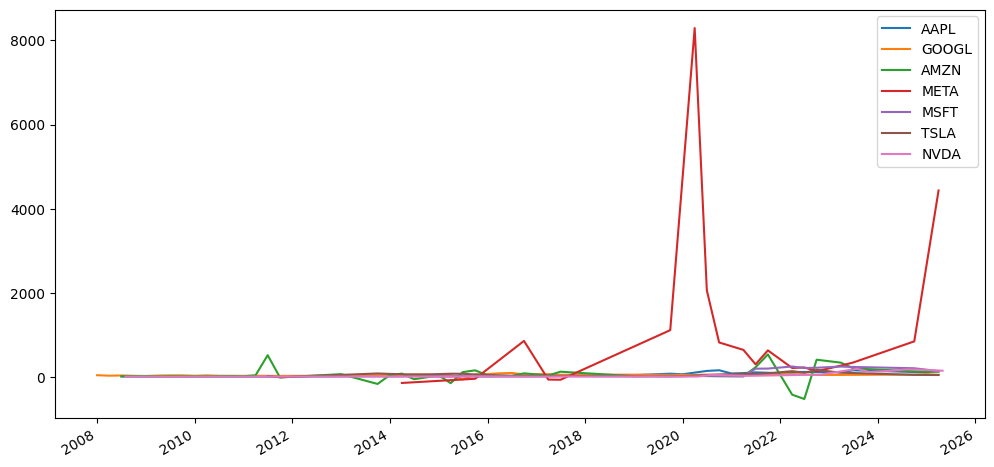

In [69]:
import matplotlib.pyplot as plt
import yfinance as yf

for company in MAG7_CIKS.values():
    eps = series[(company, "EarningsPerShareBasic", 1)]
    price = yf.Ticker(company).history(period="max")["Close"]
    price.index = price.index.tz_localize(None)
    aligned = pd.concat([eps, price], axis=1).dropna()
    aligned.columns = ["EPS", "Price"]
    aligned["P/E"] = aligned["Price"] / aligned["EPS"]

    aligned["P/E"].plot(label=company, figsize=(12, 6))

    metrics_df = pd.concat([
        metrics_df,
        pd.DataFrame({
            "Company": company,
            "Metric": "P/E",
            "Value": aligned["P/E"],
            "Date": aligned.index
        })
    ], ignore_index=True)

plt.legend()
plt.show()

###  ROE

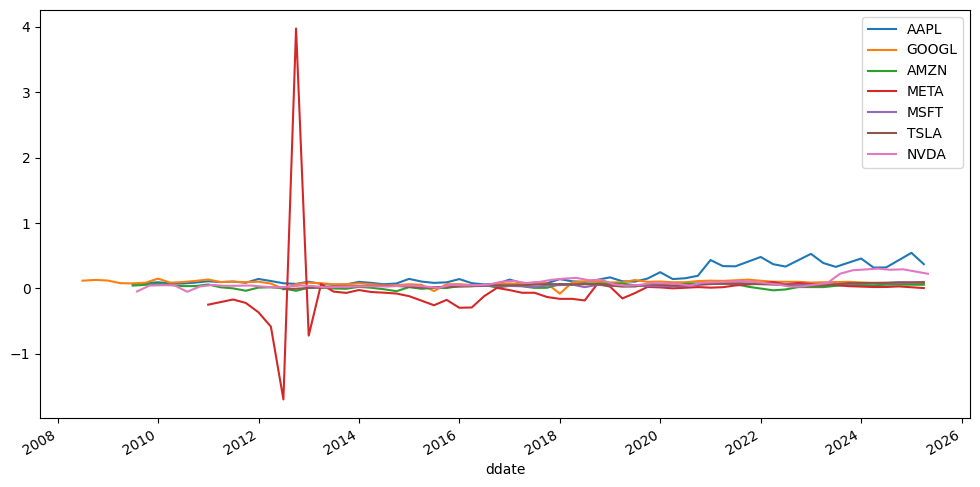

In [71]:
import matplotlib.pyplot as plt

for company in MAG7_CIKS.values():
    net_income_loss = series[(company, "NetIncomeLoss", 1)]
    stockholder_equity = series[(company, "StockholdersEquity", 0)]
    
    aligned = pd.concat([net_income_loss, stockholder_equity], axis=1).dropna()
    aligned.columns = ["NetIncomeLoss", "StockholdersEquity"]
    aligned["ROE"] = aligned["NetIncomeLoss"] / aligned["StockholdersEquity"]
    
    aligned["ROE"].plot(label=company, figsize=(12, 6))

    metrics_df = pd.concat([
        metrics_df,
        pd.DataFrame({
            "Company": company,
            "Metric": "ROE",
            "Value": aligned["ROE"],
            "Date": aligned.index
        })
    ], ignore_index=True)

plt.legend()
plt.show()

In [72]:
metrics_df

,Company,Metric,Value,Date
0,AAPL,P/E,4.158904,2008-06-30
1,AAPL,P/E,1.009891,2008-12-31
2,AAPL,P/E,1.735877,2009-03-31
3,AAPL,P/E,2.088106,2009-06-30
4,AAPL,P/E,1.975371,2009-09-30
...,...,...,...,...
610,NVDA,ROE,0.277860,2023-10-31
611,NVDA,ROE,0.302816,2024-04-30
612,NVDA,ROE,0.285417,2024-07-31
613,NVDA,ROE,0.293009,2024-10-31
